In [1]:
import os
from google.colab import drive
drive.mount('drive/')

Mounted at drive/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
os.chdir('drive/My Drive/Machinelearnia')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_excel('covid.xlsx')

In [6]:
df = df.copy()

In [7]:
df

,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Serum Glucose,Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Mycoplasma pneumoniae,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2,Neutrophils,...,Urine - Esterase,Urine - Aspect,Urine - pH,Urine - Hemoglobin,Urine - Bile pigments,Urine - Ketone Bodies,Urine - Nitrite,Urine - Density,Urine - Urobilinogen,Urine - Protein,Urine - Sugar,Urine - Leukocytes,Urine - Crystals,Urine - Red blood cells,Urine - Hyaline cylinders,Urine - Granular cylinders,Urine - Yeasts,Urine - Color,Partial thromboplastin time (PTT),Relationship (Patient/Normal),International normalized ratio (INR),Lactic Dehydrogenase,"Prothrombin time (PT), Activity",Vitamin B12,Creatine phosphokinase (CPK),Ferritin,Arterial Lactic Acid,Lipase dosage,D-Dimer,Albumin,Hb saturation (arterial blood gases),pCO2 (arterial blood gas analysis),Base excess (arterial blood gas analysis),pH (arterial blood gas analysis),Total CO2 (arterial blood gas analysis),HCO3 (arterial blood gas analysis),pO2 (arterial blood gas analysis),Arteiral Fio2,Phosphor,ctO2 (arterial blood gas analysis)
0,44477f75e8169d2,13,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126e9dd13932f68,17,negative,0,0,0,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,-0.140648,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,-0.619086,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,a46b4402a0e5696,8,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,f7d619a94f97c45,5,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,d9e41465789c2b5,15,negative,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

Création des sous enssembles suite au EDA

In [8]:
missing_rate = df.isna().sum()/df.shape[0]

In [9]:
blood_columns = df.columns[(missing_rate < 0.9)  & (missing_rate > 0.88)]
viral_columns = df.columns[(missing_rate < 0.88)  & (missing_rate > 0.75)]
viral_columns = viral_columns[:-2]

In [10]:
blood_columns.shape

(14,)

In [11]:
viral_columns.shape

(17,)

In [12]:
viral_columns[:-2].shape

(15,)

In [13]:
keys_columns = ['Patient age quantile', 'SARS-Cov-2 exam result']
keys_columns

['Patient age quantile', 'SARS-Cov-2 exam result']

In [14]:
df[keys_columns]

,Patient age quantile,SARS-Cov-2 exam result
0,13,negative
1,17,negative
2,8,negative
3,5,negative
4,15,negative
...,...,...
5639,3,positive
5640,17,negative
5641,4,negative
5642,10,negative


In [15]:
#df = pd.concat([df[keys_columns],df[blood_columns],df[viral_columns]], axis=1)  
df = pd.concat([df[keys_columns],df[blood_columns],df[viral_columns]], axis=1)  

#df = pd.concat([df[keys_columns],df[blood_columns]], axis=1)    

In [16]:
df

,Patient age quantile,SARS-Cov-2 exam result,Hematocrit,Hemoglobin,Platelets,Mean platelet volume,Red blood Cells,Lymphocytes,Mean corpuscular hemoglobin concentration (MCHC),Leukocytes,Basophils,Mean corpuscular hemoglobin (MCH),Eosinophils,Mean corpuscular volume (MCV),Monocytes,Red blood cell distribution width (RDW),Respiratory Syncytial Virus,Influenza A,Influenza B,Parainfluenza 1,CoronavirusNL63,Rhinovirus/Enterovirus,Coronavirus HKU1,Parainfluenza 3,Chlamydophila pneumoniae,Adenovirus,Parainfluenza 4,Coronavirus229E,CoronavirusOC43,Inf A H1N1 2009,Bordetella pertussis,Metapneumovirus,Parainfluenza 2
0,13,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17,negative,0.236515,-0.022340,-0.517413,0.010677,0.102004,0.318366,-0.950790,-0.094610,-0.223767,-0.292269,1.482158,0.166192,0.357547,-0.625073,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
2,8,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5639,3,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5640,17,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5641,4,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5642,10,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Train Test / Netoyage et Encodage

In [17]:
from sklearn.model_selection import train_test_split
trainset , testset = train_test_split(df, test_size=0.2, random_state=0)

In [18]:
trainset['SARS-Cov-2 exam result'].value_counts()

negative    4068
positive     447
Name: SARS-Cov-2 exam result, dtype: int64

In [19]:
testset['SARS-Cov-2 exam result'].value_counts()

negative    1018
positive     111
Name: SARS-Cov-2 exam result, dtype: int64

Encodage

In [20]:
code = {'positive':1,
        'negative':0,
        'detected':1,
        'not_detected':0}

In [21]:
for col in df.select_dtypes('object'):
  df[col] = df[col].map(code)

In [22]:
df.dtypes.value_counts()

float64    31
int64       2
dtype: int64

In [23]:
def encodage(df):
  code = {'positive':1,
        'negative':0,
        'detected':1,
        'not_detected':0}
  for col in df.select_dtypes('object'):
    df[col] = df[col].map(code)
  return df

In [24]:
#df['est malade'] = np.sum(df[viral_columns[:-2]] == 'detected', axis=1) >=1

In [25]:
#df['est malade'].value_counts()

In [26]:
def feature_engineering(df):
  df['est malade'] = df[viral_columns].sum(axis=1) >=1
  df = df.drop(viral_columns, axis=1)
  return df

In [27]:
feature_engineering


<function __main__.feature_engineering>

In [28]:
def imputation(df):
   df = df.dropna(axis=0)
   return df


In [29]:
def preprocessing(df):

  df = encodage(df)
  feature_engineering(df)
  df = imputation(df)
  x = df.drop('SARS-Cov-2 exam result', axis=1)
  y = df['SARS-Cov-2 exam result']
  print(y.value_counts())

  return x,y

In [30]:
x_train, y_train = preprocessing(trainset)

0    258
1     38
Name: SARS-Cov-2 exam result, dtype: int64


In [31]:
x_test, y_test = preprocessing(testset)

0    54
1    12
Name: SARS-Cov-2 exam result, dtype: int64


MODELISATION

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA

In [33]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))

In [34]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0) )
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier() )

In [35]:
#list_of_models = {'RandomForest':RandomForest,'AdaBoost':AdaBoost,'SVM':SVM,'KNN':KNN}
list_of_models = [RandomForest, AdaBoost, SVM, KNN]

PROCEDURE D'EVALUATION

In [36]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [37]:
def evaluation(model):
  model.fit(x_train, y_train)
  ypred = model.predict(x_test)
  print(confusion_matrix(y_test, ypred))
  print(classification_report(y_test, ypred))

  N, train_score, val_score = learning_curve(model, x_train, y_train, cv=4, scoring='f1', train_sizes=np.linspace(0.1,1,10) )
  plt.figure(figsize=(12,8))
  plt.plot(N, train_score.mean(axis=1), label='train score')
  plt.plot(N, val_score.mean(axis=1), label='validation score')
  plt.legend()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  29  31  48  51  56  57  58  62  64  83  88  94  96 114 119 125
 127 144 149 155 157 173 178 184 186 201 206 212 214 228 233 239 241 254
 259 265 267 279 284 290 292 303 308 314 316 326 331 337 339 348 353 359
 361 369 374 380 382 389 394 400 402 408 413 419 421 424 425 426 427 429
 430 431 433 434 435 436 437 438 439 442 443 444 445 446 447 448 449 451
 452 454 455 456 459 460 462 463 464 465 466 467 468 470 472 474 475 476
 477 478 479 480 481 482 483 484 485 486 487 488 490 491 493 494 495 496
 497 498 499 500 501 504 505 506 508 509 511 512 513 514 517 518 519 520
 521 522 523 524 525 526 529 530 531 532 533 534 535 536 537 539 540 541
 542 543 544 545 546 547 548 550 551 552 553 554 555 556 559 560 561 562
 563 564 567 568 569 570 571 574 575 576 577 580 581 582 584 585 586 587
 589 591 592] are constant.
  warnings.warn("Features %s are constant." % consta

[[51  3]
 [ 8  4]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        54
           1       0.57      0.33      0.42        12

    accuracy                           0.83        66
   macro avg       0.72      0.64      0.66        66
weighted avg       0.81      0.83      0.82        66



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 15  16  18  21  22  23  24  25  26  27  28  29  30  31  48  49  51  54
  55  56  57  58  59  60  61  62  63  64  80  81  83  86  87  88  89  90
  91  92  93  94  95  96 111 112 114 117 118 119 120 121 122 123 124 125
 126 127 141 142 144 147 148 149 150 151 152 153 154 155 156 157 170 171
 173 176 177 178 179 180 181 182 183 184 185 186 198 199 201 204 205 206
 207 208 209 210 211 212 213 214 225 226 228 231 232 233 234 235 236 237
 238 239 240 241 251 252 254 257 258 259 260 261 262 263 264 265 266 267
 276 277 279 282 283 284 285 286 287 288 289 290 291 292 300 301 303 306
 307 308 309 310 311 312 313 314 315 316 323 324 326 329 330 331 332 333
 334 335 336 337 338 339 345 346 348 351 352 353 354 355 356 357 358 359
 360 361 366 367 369 372 373 374 375 376 377 378 379 380 381 382 386 387
 389 392 393 394 395 396 397 398 399 400 401 402 405 406 408 411 412 413
 414 41

[[50  4]
 [ 9  3]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.88        54
           1       0.43      0.25      0.32        12

    accuracy                           0.80        66
   macro avg       0.64      0.59      0.60        66
weighted avg       0.77      0.80      0.78        66



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 16  18  21  23  24  25  26  29  30  31  48  49  51  54  56  57  58  59
  62  63  64  81  83  86  88  89  90  91  94  95  96 112 114 117 119 120
 121 122 125 126 127 142 144 147 149 150 151 152 155 156 157 171 173 176
 178 179 180 181 184 185 186 199 201 204 206 207 208 209 212 213 214 226
 228 231 233 234 235 236 239 240 241 252 254 257 259 260 261 262 265 266
 267 277 279 282 284 285 286 287 290 291 292 301 303 306 308 309 310 311
 314 315 316 324 326 329 331 332 333 334 337 338 339 346 348 351 353 354
 355 356 359 360 361 367 369 372 374 375 376 377 380 381 382 387 389 392
 394 395 396 397 400 401 402 406 408 411 413 414 415 416 419 420 421 424
 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 441 442 443
 444 445 446 447 448 449 450 451 452 453 454 455 456 457 459 460 461 462
 463 464 465 466 467 468 469 470 471 472 474 475 476 477 478 479 480 481
 482 48

[[51  3]
 [ 8  4]]
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        54
           1       0.57      0.33      0.42        12

    accuracy                           0.83        66
   macro avg       0.72      0.64      0.66        66
weighted avg       0.81      0.83      0.82        66



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  29  31  48  51  56  57  58  62  64  83  88  94  96 114 119 125
 127 144 149 155 157 173 178 184 186 201 206 212 214 228 233 239 241 254
 259 265 267 279 284 290 292 303 308 314 316 326 331 337 339 348 353 359
 361 369 374 380 382 389 394 400 402 408 413 419 421 424 425 426 427 429
 430 431 433 434 435 436 437 438 439 442 443 444 445 446 447 448 449 451
 452 453 454 455 456 459 460 462 463 464 465 466 467 468 470 472 474 475
 476 477 478 479 480 481 482 483 484 485 486 487 488 490 491 493 494 495
 496 497 498 499 500 501 504 505 506 508 509 511 512 513 514 517 518 519
 520 521 522 523 524 525 526 529 530 531 532 533 534 535 536 537 539 540
 541 542 543 544 545 546 547 548 550 551 552 553 554 555 556 559 560 561
 562 563 564 567 568 569 570 571 574 575 576 577 580 581 582 584 585 586
 587 589 591 592] are constant.
  warnings.warn("Features %s are constant." % co

[[49  5]
 [ 8  4]]
              precision    recall  f1-score   support

           0       0.86      0.91      0.88        54
           1       0.44      0.33      0.38        12

    accuracy                           0.80        66
   macro avg       0.65      0.62      0.63        66
weighted avg       0.78      0.80      0.79        66



/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 18  23  29  31  48  49  51  56  57  58  62  64  83  88  94  96 114 119
 125 127 144 149 155 157 173 178 184 186 201 206 212 214 228 233 239 241
 254 259 265 267 279 284 290 292 303 308 314 316 326 331 337 339 348 353
 359 361 369 374 380 382 389 394 400 402 408 413 419 421 424 425 426 427
 429 430 431 433 434 435 436 437 438 439 442 443 444 445 446 447 448 449
 451 452 453 454 455 456 459 460 461 462 463 464 465 466 467 468 469 470
 471 472 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 490
 491 492 493 494 495 496 497 498 499 500 501 504 505 506 508 509 511 512
 513 514 517 518 519 520 521 522 523 524 525 526 529 530 531 532 533 534
 535 536 537 539 540 541 542 543 544 545 546 547 548 550 551 552 553 554
 555 556 559 560 561 562 563 564 567 568 569 570 571 574 575 576 577 580
 581 582 584 585 586 587 589 591 592] are constant.
  warnings.warn("Features %s

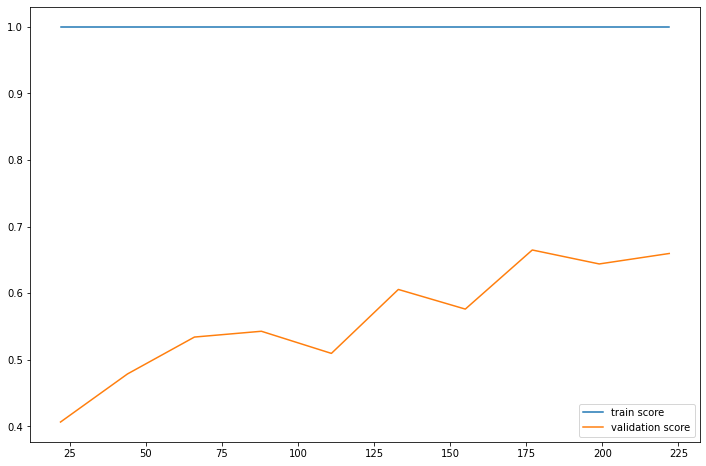

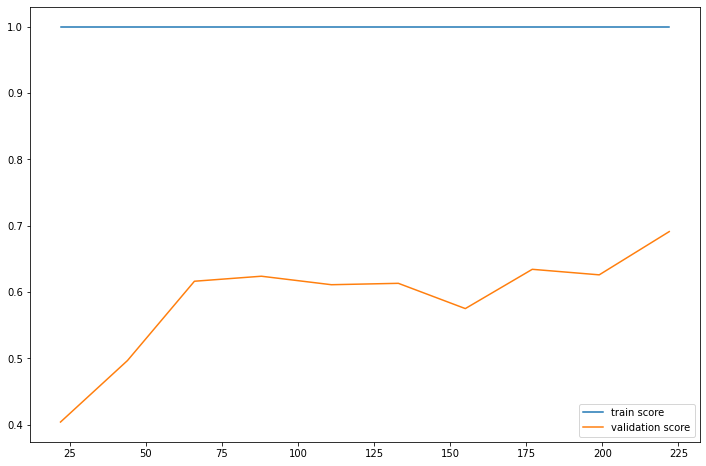

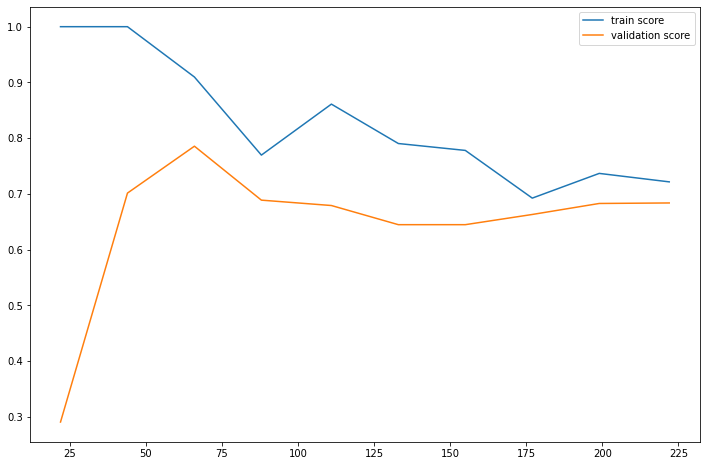

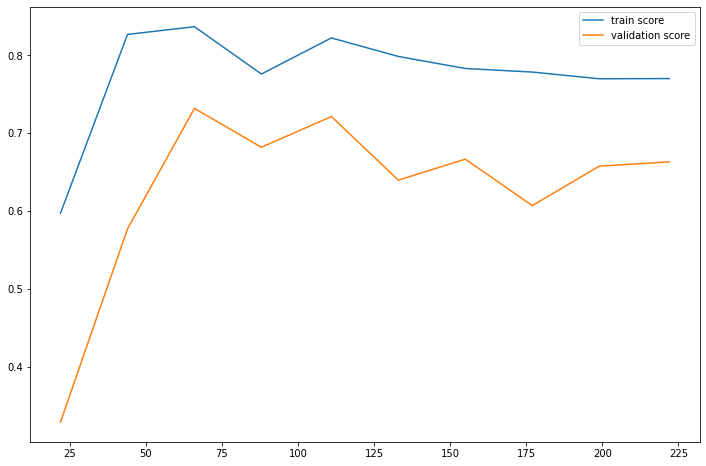

In [38]:
for model in list_of_models:
 
  evaluation(model) # Ici nous somme dans le cas de l'overfitting

OPTIMISATION

In [39]:
from sklearn.model_selection import GridSearchCV

In [40]:
SVM

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('polynomialfeatures',
                                  PolynomialFeatures(include_bias=False)),
                                 ('selectkbest', SelectKBest())])),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=0))])

In [41]:
hyper_params = {'svc__gama':[1e-3, 1e-4], 'svc__C':[1, 10, 100, 1000]}

In [42]:
grid = GridSearchCV(SVM, hyper_params, scoring='recall', cv=4)

grid.fit(x_train, y_train)
print(grid.best_params_)
y_pred = grid.predict(x_test)
print(classification_report(y_test, y_pred))



ValueError: ignored

In [43]:
estimator.get_params().keys()

NameError: ignored